### Cosmological Parameter inference from convergence ($\kappa$) maps using Bayesian Neural Networks (BNNs).

Using the Cosmogrid simulations.

In [2]:
#! apt-get update
#!sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#!apt install cm-super
#!pip install chainconsumer

In [3]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd


# Colab in order to download files
from google.colab import files

# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Chainconsumer
from chainconsumer import ChainConsumer

# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

### Import Tensorflow, TensorFlow Probability, Keras

In [4]:
# Tensorflow and Keras
import tensorflow as tf
import tensorflow_probability as tfp


from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# Import some layers etc that are useful in the Functional approach
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LeakyReLU

**Import Dataset**

In [5]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define the data path
PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Datasets/'

# IMAGE PATH
PLT_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Plots/'

# MODEL WEIGHTS PATH
MDL_WEIGHTS_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Saved_Models/'

In [17]:
# Load maps
X_maps = np.float64(np.load(PATH+"maps_all_collage_flask_6cosmo_n625_jr0_wSN0_jz3.npz.npy",mmap_mode='r'))[:100000]

# Load labels
y_cosmo = np.float64(np.load(PATH+"cosmo_params_all_collage_flask_6cosmo_n625_jr0_wSN0_jz3.npz.npy"))[:100000]

Print the shape of the data

In [8]:
print(np.shape(X_maps),np.shape(y_cosmo))

(100000, 66, 66) (100000, 6)


In [9]:
# Garbage collector to free up memory
import gc

### Keep subsets of the data as training, validation, and test sets

The original dataset is very large, so for that reason we will keep a much smaller dataset for our purposes here.

In [18]:
# Keep a number of maps for training, validation, and testing
X_train = X_maps[:80000]
X_val = X_maps[80000:90000]
X_test = X_maps[90000:]

# Delete the full, large dataset to free memory
del X_maps

In [19]:
gc.collect()

935

In [20]:
# The same for the labels
y_train = y_cosmo[:80000,:5]
y_val = y_cosmo[80000:90000,:5]
y_test = y_cosmo[90000:,:5]

In [21]:
del y_cosmo

### **Exploratory data analysis**

Let's plot the distribution in cosmological parameters and also some maps.

The order of cosmological parameters is:  $\Omega_m$, $H_0$, $n_s$, $\sigma_8$, $w_0$.

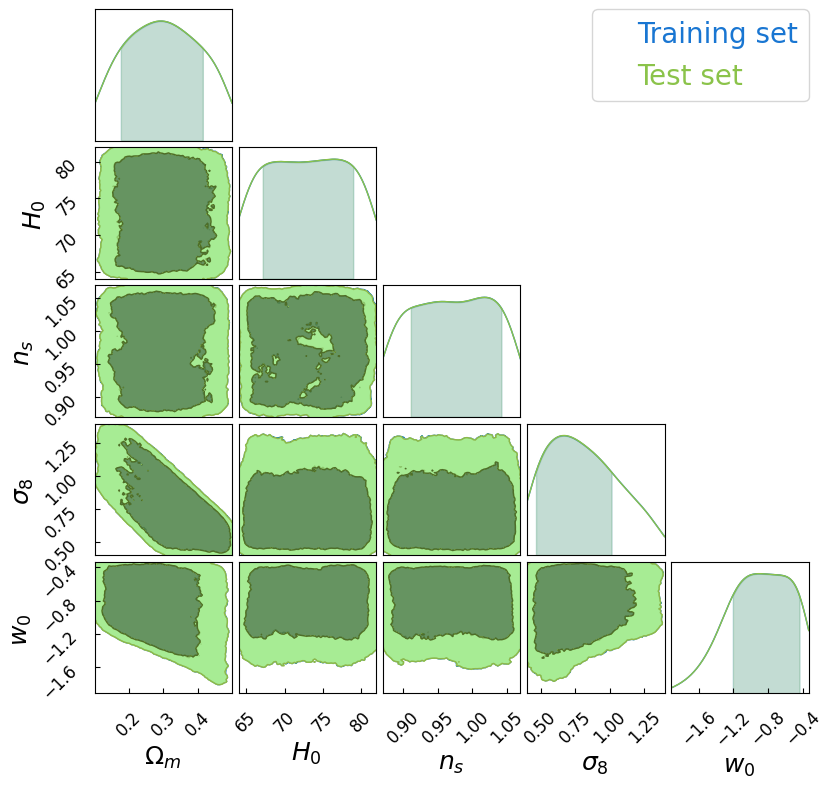

In [26]:
plot_pretty()
params = ["$\Omega_m$", "$H_0$", "$n_s$",'$\sigma_8$','$w_0$']



c = ChainConsumer()
c.add_chain(y_train[:5000],parameters=params,name='Training set')
#c.add_chain(y_val[:5000],parameters=params,name='Validation set')
c.add_chain(y_test[:5000],parameters=params,name='Test set')


# Configure plot
c.configure(label_font_size=18,max_ticks=4,tick_font_size=12,
            legend_kwargs={"frameon":True, "fontsize":20}, kde=True)

fig = c.plotter.plot(figsize=(8.4,8.05))


#plt.tight_layout()
plt.savefig(PLT_PATH+"Distribution_Cosmogrid.pdf")
plt.show()

#### Data Pre-processing

Now, for simplicity we will train a model to predict only: $\Omega_m - \sigma_8$.

In [24]:
y_cosmo = np.float64(np.load(PATH+"cosmo_params_all_collage_flask_6cosmo_n625_jr0_wSN0_jz3.npz.npy"))[:100000] 

# Get omega and sigma 8
y_Omega = y_cosmo[:,0];y_sigma_8 = y_cosmo[:,3]

In [27]:
# Labels for two cosmological parameters 
y_cosmo_2 = np.stack([y_Omega,y_sigma_8],axis=-1)

# Split into training, validation, test sets
y_train  = y_cosmo_2[:80000]
y_val = y_cosmo_2[80000:90000]
y_test = y_cosmo_2[90000:]

# Delete what we do not need any more
del y_cosmo_2, y_cosmo, y_Omega, y_sigma_8

Pre-process the labels

In [28]:
# Define the scaler
scaler = MinMaxScaler()

# Fit the scaler 
scaler.fit(y_train)

# Rescale
y_train_sc = scaler.transform(y_train)
y_val_sc = scaler.transform(y_val)
y_test_sc = scaler.transform(y_test)

Make a plot of some maps

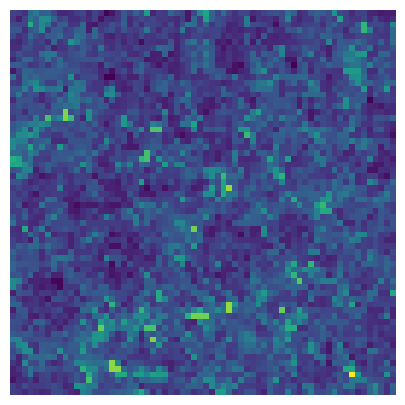

In [30]:
i_map = 30

plt.figure(figsize=(10,5))
plt.imshow(X_train[i_map],cmap='viridis')
plt.axis('off')
plt.savefig(PLT_PATH+"Example_Map.pdf")


(-0.5, 65.5, 65.5, -0.5)

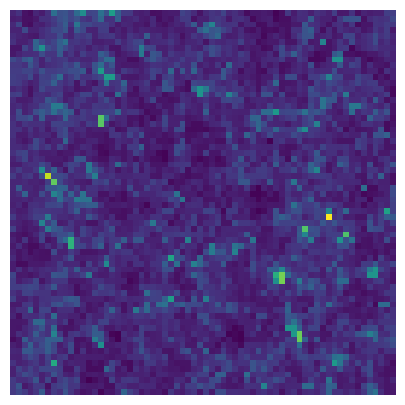

In [ ]:
i_map = 50

plt.figure(figsize=(10,5))
plt.imshow(X_train[i_map],cmap='viridis')
plt.axis('off')

### Define and train a Bayesian Neural Network

In [31]:
# Define basic numbers
IMAGE_SHAPE = [66,66,1]
NUM_TRAIN_EXAMPLES = 80000
NUM_VAL_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 10000
NUM_CLASSES = 2

In [32]:
# Define KL divergence
tfd = tfp.distributions

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                           tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

In [33]:
# Clears session when running this cell
tf.keras.backend.clear_session()

# Alpha for LeakyRelu
al_rel = 0.05
reg_str = 0.0001 #Apply a regularization


# Bayesian model in functional form
model_input = Input(shape=(66,66,1))


# Convolutional part =================
# 1st convolutional chunk 
x = tfp.layers.Convolution2DFlipout(
          filters = 12, 
          kernel_size=(4,4),
          padding='valid',
          kernel_divergence_fn=kl_divergence_function)(model_input)
x = LeakyReLU(alpha=al_rel)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)


# 2nd convolutional chunk 
x = tfp.layers.Convolution2DFlipout(
          filters = 2*12, 
          kernel_size=(4,4),
          padding='valid',
          kernel_divergence_fn=kl_divergence_function)(model_input)
x = LeakyReLU(alpha=al_rel)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)

# 3rd convolutional chunk 
x = tfp.layers.Convolution2DFlipout(
          filters = 4*12, 
          kernel_size=(3,3),
          padding='valid',
          kernel_divergence_fn=kl_divergence_function)(model_input)
x = LeakyReLU(alpha=al_rel)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)

# =========================================
x = keras.layers.Flatten()(x)
# =========================================
# =========================================

x = tfp.layers.DenseFlipout(units = 128, 
          kernel_divergence_fn=kl_divergence_function)(x)
x = keras.layers.LeakyReLU(alpha=al_rel)(x)
x = tfp.layers.DenseFlipout(units = 64, 
          kernel_divergence_fn=kl_divergence_function)(x)
x = keras.layers.LeakyReLU(alpha=al_rel)(x)
x = tfp.layers.DenseFlipout(units = 32,
          kernel_divergence_fn=kl_divergence_function)(x)
x = keras.layers.LeakyReLU(alpha=al_rel)(x)


distribution_params = keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(2))(x)
model_output = tfp.layers.MultivariateNormalTriL(event_size=2)(distribution_params)
model = Model(model_input, model_output)


/usr/local/lib/python3.9/dist-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.9/dist-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [34]:
# Define the optimizer 
optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.1,rho=0.9,epsilon=1e-07)

In [35]:
# Define loss
def negloglik(y_true, y_pred):    
    return -tf.reduce_mean(y_pred.log_prob(y_true))


# Compile the model
model.compile(optimizer,
              loss=negloglik,
              metrics=['mae'],experimental_run_tf_function=False)

In [36]:
EPOCHS = 160

model.fit(x=X_train, y=y_train_sc,
          epochs=EPOCHS,
          batch_size=2*64,
          shuffle=True,
          validation_data=(X_val,y_val_sc))

Epoch 1/160
625/625 [==============================] - 26s 18ms/step - loss: 199.9684 - mae: 0.4332 - val_loss: 199.4751 - val_mae: 0.3474
Epoch 2/160
625/625 [==============================] - 8s 13ms/step - loss: 199.3011 - mae: 0.3271 - val_loss: 199.1904 - val_mae: 0.3176
Epoch 3/160
625/625 [==============================] - 8s 13ms/step - loss: 199.1246 - mae: 0.3111 - val_loss: 199.0853 - val_mae: 0.3048
Epoch 4/160
625/625 [==============================] - 8s 13ms/step - loss: 198.9928 - mae: 0.3056 - val_loss: 198.9152 - val_mae: 0.3022
Epoch 5/160
625/625 [==============================] - 8s 13ms/step - loss: 198.8110 - mae: 0.2981 - val_loss: 198.6731 - val_mae: 0.2926
Epoch 6/160
625/625 [==============================] - 8s 13ms/step - loss: 198.5424 - mae: 0.2896 - val_loss: 198.4660 - val_mae: 0.2882
Epoch 7/160
625/625 [==============================] - 8s 13ms/step - loss: 198.3232 - mae: 0.2827 - val_loss: 198.2443 - val_mae: 0.2793
Epoch 8/160
625/625 [============

In [37]:
model.save_weights(MDL_WEIGHTS_PATH+'BNN_network__COSMOGRID_weights.h5',overwrite=True)

In [38]:
history_dict = model.history.history

train_mae = history_dict['mae']
val_mae = history_dict['val_mae']

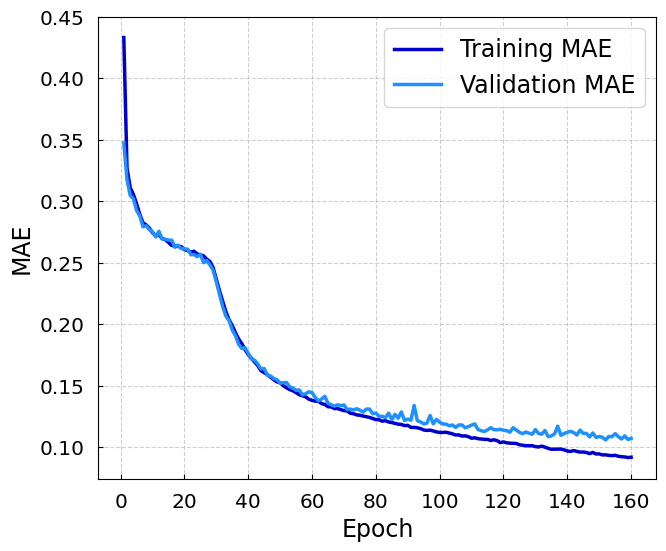

In [39]:
Epochs_sp = np.arange(1,EPOCHS+1,1)


plt.figure(figsize=(7.2, 6.0))

# Plot MAE
plt.plot(Epochs_sp, train_mae, c = 'mediumblue',linewidth=2.5,label='Training MAE')
plt.plot(Epochs_sp, val_mae, c = 'dodgerblue',linewidth=2.5,label='Validation MAE')

# ==========================================
# ==========================================
plt.grid(ls='--',alpha=0.6)
plt.xlabel('Epoch', fontsize=17);plt.ylabel('MAE',fontsize=17)
plt.legend(frameon=True, loc='upper right', fontsize=17)
plt.tick_params(axis='both', labelsize=14.5)

#plt.xlim(20,)
#plt.ylim(0.0,0.5)
plt.savefig(PLT_PATH+"MAE_COSMOGRID.pdf")
#files.download("/content/drive/My Drive/BNN_Final_Codes/Plots/MAE.pdf",bbox_inches='tight'")
plt.show()

### Make predictions

In [40]:
n_test = 1000

X_keep = X_test[:n_test]
y_keep = y_test[:n_test]
y_keep_sc = y_test_sc[:n_test]

In [41]:
print(np.shape(X_test))

(10000, 66, 66)


In [42]:
pred_dist = model(X_keep)
sample = np.asarray(pred_dist.sample(300))

#print(np.shape(sample))

n_rands = 100

#Time it
#tim_in = time.time()

for i in range(n_rands):
  print(i)
  pred_dist = model(X_keep)
  sample_loc = np.asarray(pred_dist.sample(300))
  sample = np.concatenate((sample,sample_loc))


#tim_fin = time.time()
print("Time for the BNN predictions to run (in minutes):")
#print((tim_fin-tim_in)/60.0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Time for the BNN predictions to run (in minutes):


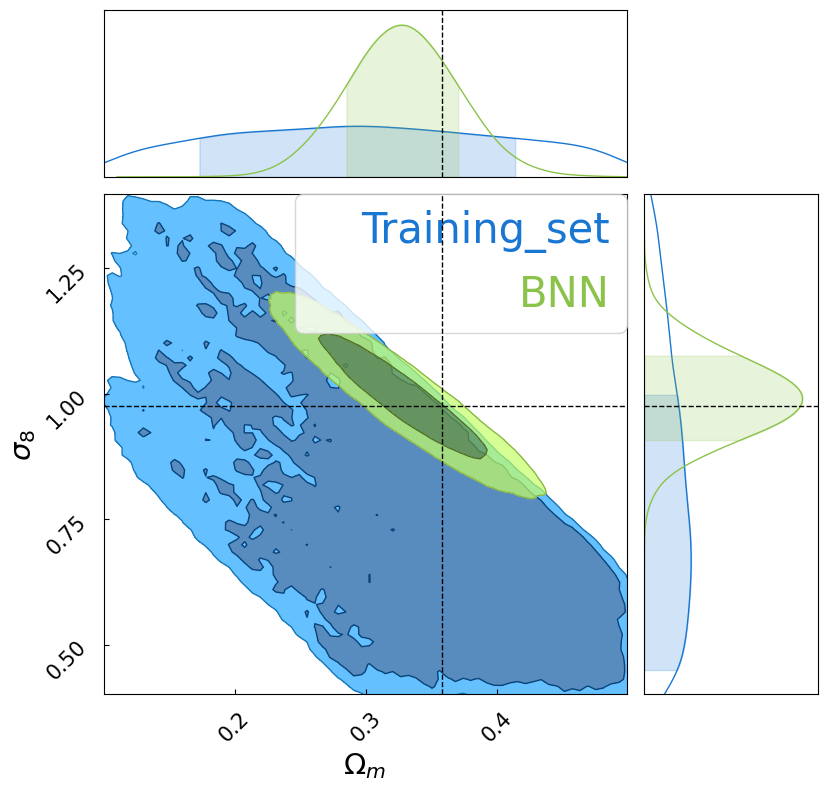

In [43]:
j = 150

sample_new_single = scaler.inverse_transform(np.asarray(sample[:,j,:]))

params = ["$\Omega_m$", "$\sigma_8$"]


c = ChainConsumer()
c.add_chain(y_train,parameters=params,name='Training_set')
c.add_chain(sample_new_single,parameters=params,name='BNN')

# Configure plot
c.configure(label_font_size=21,max_ticks=4,tick_font_size=15,
            legend_kwargs={"frameon":True, "fontsize":30}, kde=True)

fig = c.plotter.plot(figsize=(8.4,8.05), truth=y_keep[j])
plt.savefig(PLT_PATH+"Example_Constraints_COSMOGRID.pdf")
plt.show()

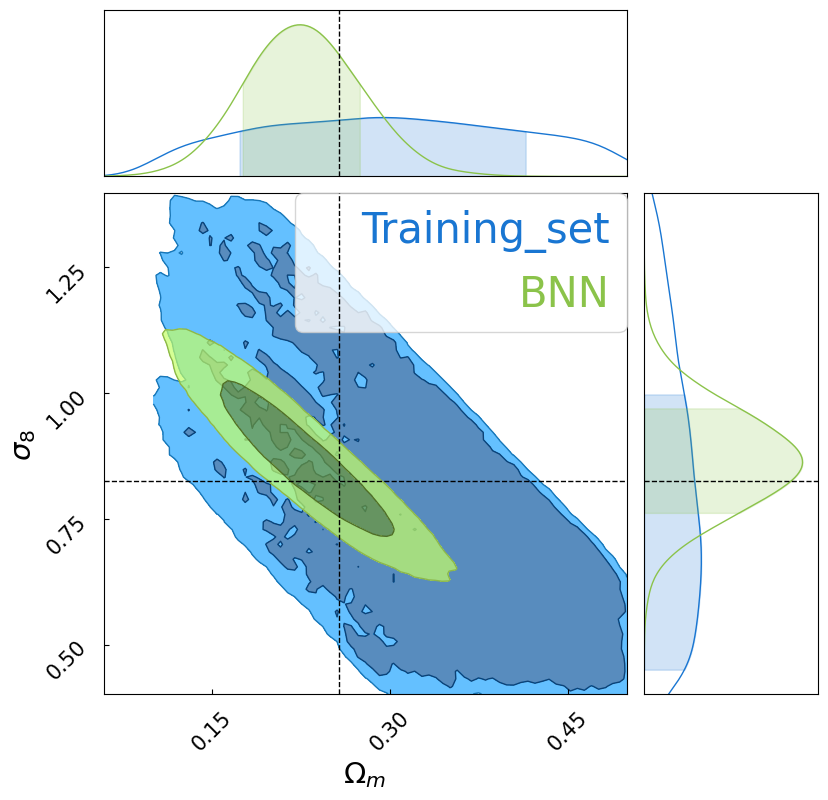

In [ ]:
j = 400

sample_new_single = scaler.inverse_transform(np.asarray(sample[:,j,:]))

params = ["$\Omega_m$", "$\sigma_8$"]


c = ChainConsumer()
c.add_chain(y_train,parameters=params,name='Training_set')
c.add_chain(sample_new_single,parameters=params,name='BNN')

# Configure plot
c.configure(label_font_size=21,max_ticks=4,tick_font_size=15,
            legend_kwargs={"frameon":True, "fontsize":30}, kde=True)

fig = c.plotter.plot(figsize=(8.4,8.05), truth=y_keep[j])
plt.savefig(PLT_PATH+"Example_Constraints_COSMOGRID_2.pdf")
plt.show()

### **Calibration Plot**

In [44]:
inv_sample = []

for i in range(n_test):
  inv_sample_loc = scaler.inverse_transform(sample[:,i,:])
  inv_sample.append(inv_sample_loc)

In [45]:
print(np.shape(inv_sample))

(1000, 30300, 2)


In [46]:
np.save(MDL_WEIGHTS_PATH+"samples_test_BNN.npy",inv_sample)

In [47]:
def mahalanobis_dist(param_vector, mean_vector, covariance):
  """
  Param vector: [n_samples, n_params]
  """
  # Get number of samples and number of parameters
  n_samples, n_params = np.shape(param_vector)

  # Get inverse covariance
  inv_cov = np.linalg.inv(covariance)

  # Initialize vector of distances
  dist_vect = np.zeros(n_samples)
  # Populate
  for i in range(n_samples):
    diff_i = np.array(param_vector[i] - mean_vector)
    dist_vect[i] = np.sqrt(np.dot(diff_i.T,np.dot(inv_cov,diff_i)))

  return dist_vect 

In [48]:
def prob_coverage(sample, true_params, percentile_list):
  """

  """
  # Get the number of instances, samples, and parameters
  n_inst, n_sample, n_params = np.shape(sample)

  print(n_inst, n_sample, n_params)

  
  #Initialize 
  prob_vol = np.zeros(n_inst)
  for i in range(n_inst):
    # Get array of samples of the i-th instance
    sample_i = sample[i,:,:]
    # Get mean vector and covariance matrix 
    mean = np.mean(sample_i,axis=0)
    cov = np.cov(sample_i,rowvar=False)

    # Get true parameters of the i-th instance
    true_params_i = true_params[i].reshape(1,len(true_params[i]))

    # Get Mahalanobis distances of the samples and the true value
    d_sample_i = mahalanobis_dist(sample_i,mean,cov)
    d_true_i = mahalanobis_dist(true_params_i,mean,cov)

    diff = d_sample_i - d_true_i
    prob_vol[i] = sum(diff<0)/n_sample
  # ==========================================
  # ==========================================
  
  n_perc = len(percentile_list)
  prob_cov = np.zeros(n_perc)

  for i in range(n_perc):
    prob_cov[i] = sum(prob_vol-percentile_list[i]<0)/n_inst

  return prob_cov


percentiles = np.linspace(0,1,50)
prob_covs = prob_coverage(np.asarray(inv_sample),y_keep,percentiles)

1000 30300 2


In [49]:
print(np.shape(y_keep))

(1000, 2)


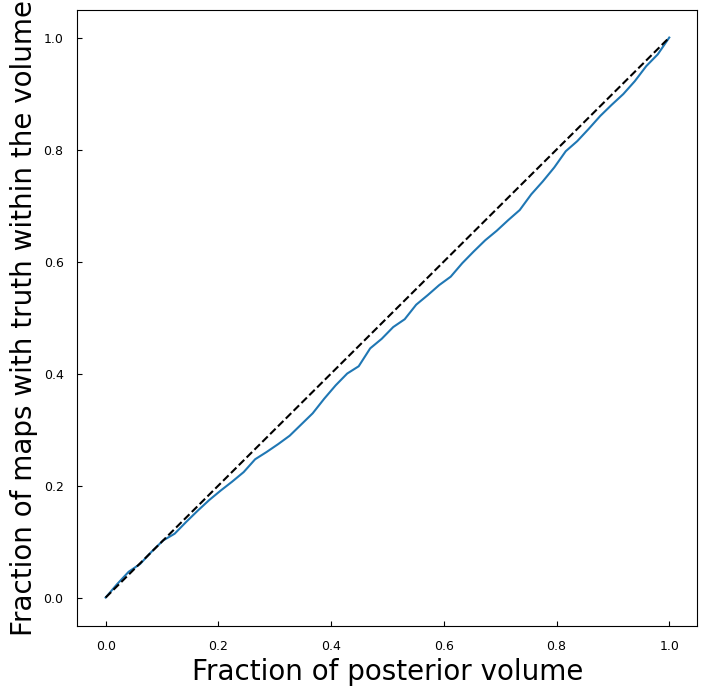

In [51]:
x = np.linspace(0,1,100)
plt.figure(figsize=(8., 8.))


plt.plot(percentiles,prob_covs)
plt.plot(x,x,ls='--',c='k')


plt.xlabel('Fraction of posterior volume',fontsize=20)
plt.ylabel('Fraction of maps with truth within the volume',fontsize=20)

plt.show()